# Liriscat paper experiments
### 1. Init
#### 1.1. Import libraries (necessary)

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["PYTHONHASHSEED"] = "0"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

import liriscat
liriscat.utils.set_seed(0)

import logging
import gc
import json
import torch
liriscat.utils.set_seed(0)
import pandas as pd
from importlib import reload

#### 1.2. Set up the loggers (recommended)

In [2]:
liriscat.utils.setuplogger(verbose = True, log_name="liriscat", debug=False)

### 2. CDM prediction
#### 2.1. Training and testing, sequential version

In [3]:
import warnings

gc.collect()
torch.cuda.empty_cache()

In [4]:
config = liriscat.utils.generate_eval_config(load_params=True, esc = 'error', valid_metric= 'mi_acc', pred_metrics = ["mi_acc"], profile_metrics = ['meta_doa'], save_params=False, n_query=10, num_epochs=30, batch_size=512)
liriscat.utils.set_seed(config["seed"])

config['patience'] = 5
config['num_inner_users_epochs'] = 3
config['inner_user_lr'] = 0.02026
config['meta_trainer'] = 'GAP'

config["dataset_name"] = "math2"
logging.info(config["dataset_name"])
config['learning_rate'] = 0.02026
config['lambda'] = 1.2e-5
config['d_in'] = 4
config['num_responses'] = 12
#pred_metrics,df_interp = test(config)

CUDA is available. Using GPU.
[INFO 13:36] math2


In [5]:
logging.info(f'#### {config["dataset_name"]} ####')
logging.info(f'#### config : {config} ####')
config['embs_path']='../embs/'+str(config["dataset_name"])
config['params_path']='../ckpt/'+str(config["dataset_name"])

pred_metrics = {m:[] for m in config['pred_metrics']}
profile_metrics = {m:[] for m in config['profile_metrics']}

gc.collect()
torch.cuda.empty_cache()

# Dataset downloading for doa and rm
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Concept map format : {question_id : [category_id1, category_id2, ...]}
concept_map = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

## Metadata map format : {"num_user_id": ..., "num_item_id": ..., "num_dimension_id": ...}
metadata = json.load(open(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'))


## Tensor containing the nb of modalities per question
nb_modalities = torch.load(f'../datasets/2-preprocessed_data/{config["dataset_name"]}_nb_modalities.pkl',weights_only=True)


[INFO 13:37] #### math2 ####
[INFO 13:37] #### config : {'seed': 0, 'dataset_name': 'math2', 'load_params': True, 'save_params': False, 'embs_path': '../embs/', 'params_path': '../ckpt/', 'early_stopping': True, 'esc': 'error', 'verbose_early_stopping': False, 'disable_tqdm': False, 'valid_metric': 'mi_acc', 'learning_rate': 0.02026, 'batch_size': 512, 'valid_batch_size': 10000, 'num_epochs': 30, 'eval_freq': 1, 'patience': 5, 'device': device(type='cuda'), 'lambda': 1.2e-05, 'tensorboard': False, 'flush_freq': True, 'pred_metrics': ['mi_acc'], 'profile_metrics': ['meta_doa'], 'num_responses': 12, 'low_mem': False, 'n_query': 10, 'CDM': 'impact', 'i_fold': 0, 'num_inner_users_epochs': 3, 'num_inner_epochs': 10, 'inner_lr': 0.0001, 'inner_user_lr': 0.02026, 'meta_trainer': 'GAP', 'num_workers': 0, 'pin_memory': False, 'debug': False, 'd_in': 4} ####


In [6]:
def pareto_index(d) : 
    d_acc = d[0]
    d_meta = d[1]

    r = []

    for i in range(len(d_acc)):
        r.append(d_acc[i]['mi_acc']*d_meta[i]['meta_doa'])
    print(sum(r))

In [9]:
for i_fold in range(1,5) : 
    config['i_fold'] = i_fold
    logging.info(f'#### i_fold : {i_fold} ####')
    ## Dataframe columns : (user_id, question_id, response, category_id)
    train_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
        encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                                 "dimension_id": int})
    valid_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
        encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                                 "dimension_id": int})
    test_df = pd.read_csv(
        f'../datasets/2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
        encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                                 "dimension_id": int})

    train_data = liriscat.dataset.CATDataset(train_df, concept_map, metadata, config,nb_modalities)
    valid_data = liriscat.dataset.EvalDataset(valid_df, concept_map, metadata, config,nb_modalities)
    test_data = liriscat.dataset.EvalDataset(test_df, concept_map, metadata, config,nb_modalities)

    S = liriscat.selectionStrategy.Random(metadata,**config)
    S.init_models(train_data, valid_data)
    S.train(train_data, valid_data)
    liriscat.utils.set_seed(0)
    S.reset_rng()
    d = (S.evaluate_test(test_data, train_data, valid_data))
    print(d)
    pareto_index(d)

[INFO 57:20] #### i_fold : 1 ####
[INFO 57:29] Random_cont_model
[INFO 57:29] compiling CDM model
[INFO 57:29] compiling selection model
[INFO 57:29] ------- START Training
[INFO 57:29] train on cuda


/home/arthur/liriscat/liriscat/selectionStrategy/random.py:30: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
  0%|          | 0/30 [00:00<?, ?it/s]

valid L1 : 0.10238572210073471, valid L3 : 0.8731625080108643, valid R : 2025.668212890625
[INFO 58:19] valid_loss : 0.2839963138103485


  3%|▎         | 1/30 [00:48<23:40, 48.98s/it]

valid L1 : 0.09385281801223755, valid L3 : 0.8780546188354492, valid R : 1359.870849609375
[INFO 59:09] valid_loss : 0.2587869465351105


  7%|▋         | 2/30 [01:38<23:07, 49.57s/it]

valid L1 : 0.08412691205739975, valid L3 : 0.8967017531394958, valid R : 996.9367065429688
[INFO 00:00] valid_loss : 0.2564127743244171


 10%|█         | 3/30 [02:30<22:37, 50.29s/it]

valid L1 : 0.09114949405193329, valid L3 : 0.8852723240852356, valid R : 1209.510498046875
[INFO 00:51] valid_loss : 0.26291462779045105


 13%|█▎        | 4/30 [03:21<21:56, 50.64s/it]

valid L1 : 0.0956653580069542, valid L3 : 0.8734835386276245, valid R : 1429.332275390625
[INFO 01:41] valid_loss : 0.26494455337524414


 17%|█▋        | 5/30 [04:11<21:01, 50.45s/it]

valid L1 : 0.09979259222745895, valid L3 : 0.8688107132911682, valid R : 1517.576904296875
[INFO 02:31] valid_loss : 0.27369627356529236


 20%|██        | 6/30 [05:01<20:07, 50.31s/it]

valid L1 : 0.10229941457509995, valid L3 : 0.8649516701698303, valid R : 1624.066650390625
[INFO 03:21] valid_loss : 0.28186774253845215


 23%|██▎       | 7/30 [05:51<19:12, 50.12s/it]

valid L1 : 0.10527565330266953, valid L3 : 0.8650530576705933, valid R : 1652.7666015625
[INFO 04:11] valid_loss : 0.28980037569999695


 23%|██▎       | 7/30 [06:41<21:58, 57.31s/it]

[INFO 04:11] -- END Training --
[INFO 04:11] train on cuda



100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


({0: {'mi_acc': 0.6987358331680298}, 1: {'mi_acc': 0.698336660861969}, 2: {'mi_acc': 0.6940785050392151}, 3: {'mi_acc': 0.7023286819458008}, 4: {'mi_acc': 0.7019294500350952}, 5: {'mi_acc': 0.7016633152961731}, 6: {'mi_acc': 0.699268102645874}, 7: {'mi_acc': 0.7027278542518616}, 8: {'mi_acc': 0.6990019679069519}, 9: {'mi_acc': 0.7052561044692993}}, {0: {'meta_doa': 0.7348493590700207}, 1: {'meta_doa': 0.7407728337498414}, 2: {'meta_doa': 0.7466102875744813}, 3: {'meta_doa': 0.7527167335384894}, 4: {'meta_doa': 0.7587013572041754}, 5: {'meta_doa': 0.7638678859713598}, 6: {'meta_doa': 0.7685892569013142}, 7: {'meta_doa': 0.7723946701094785}, 8: {'meta_doa': 0.7756456020341892}, 9: {'meta_doa': 0.7789824673478142}})
5.317961152795153
[INFO 04:33] #### i_fold : 2 ####
[INFO 04:42] Random_cont_model
[INFO 04:42] compiling CDM model
[INFO 04:42] compiling selection model
[INFO 04:42] ------- START Training
[INFO 04:42] train on cuda


/home/arthur/liriscat/liriscat/selectionStrategy/random.py:30: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
  0%|          | 0/30 [00:00<?, ?it/s]

valid L1 : 0.09873777627944946, valid L3 : 0.8759015798568726, valid R : 2060.37060546875
[INFO 05:33] valid_loss : 0.29030749201774597


  3%|▎         | 1/30 [00:50<24:32, 50.76s/it]

valid L1 : 0.09436452388763428, valid L3 : 0.8777003288269043, valid R : 1444.6661376953125
[INFO 06:24] valid_loss : 0.29318541288375854


  7%|▋         | 2/30 [01:41<23:34, 50.51s/it]

valid L1 : 0.08173428475856781, valid L3 : 0.8940593004226685, valid R : 1031.949462890625
[INFO 07:14] valid_loss : 0.27577823400497437


 10%|█         | 3/30 [02:32<22:48, 50.70s/it]

valid L1 : 0.08669421821832657, valid L3 : 0.8893069624900818, valid R : 1177.3399658203125
[INFO 08:06] valid_loss : 0.2785490155220032


 13%|█▎        | 4/30 [03:23<22:09, 51.13s/it]

valid L1 : 0.09527529776096344, valid L3 : 0.8770950436592102, valid R : 1427.0926513671875
[INFO 08:58] valid_loss : 0.28266701102256775


 17%|█▋        | 5/30 [04:15<21:22, 51.29s/it]

valid L1 : 0.09890635311603546, valid L3 : 0.8726010918617249, valid R : 1548.9005126953125
[INFO 09:48] valid_loss : 0.2894924581050873


 20%|██        | 6/30 [05:05<20:25, 51.06s/it]

valid L1 : 0.10136229544878006, valid L3 : 0.8758718967437744, valid R : 1608.540283203125
[INFO 10:39] valid_loss : 0.29705050587654114


 23%|██▎       | 7/30 [05:56<19:32, 50.96s/it]

valid L1 : 0.1021064966917038, valid L3 : 0.8761465549468994, valid R : 1570.9766845703125
[INFO 11:30] valid_loss : 0.3026621639728546


 23%|██▎       | 7/30 [06:47<22:18, 58.21s/it]

[INFO 11:30] -- END Training --
[INFO 11:30] train on cuda



100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


({0: {'mi_acc': 0.6870259046554565}, 1: {'mi_acc': 0.6998003721237183}, 2: {'mi_acc': 0.6958083510398865}, 3: {'mi_acc': 0.7085828185081482}, 4: {'mi_acc': 0.7065867781639099}, 5: {'mi_acc': 0.7056553363800049}, 6: {'mi_acc': 0.7049899697303772}, 7: {'mi_acc': 0.706852912902832}, 8: {'mi_acc': 0.7115103006362915}, 9: {'mi_acc': 0.7087158560752869}}, {0: {'meta_doa': 0.7420978925898805}, 1: {'meta_doa': 0.7485025240765185}, 2: {'meta_doa': 0.7542877433578068}, 3: {'meta_doa': 0.7597665460652698}, 4: {'meta_doa': 0.7663837224770829}, 5: {'meta_doa': 0.7723938907610646}, 6: {'meta_doa': 0.7775750418683307}, 7: {'meta_doa': 0.7820883904120808}, 8: {'meta_doa': 0.7851130477593007}, 9: {'meta_doa': 0.7887356847974121}})
5.4020100973766265
[INFO 11:52] #### i_fold : 3 ####
[INFO 12:01] Random_cont_model
[INFO 12:01] compiling CDM model
[INFO 12:01] compiling selection model
[INFO 12:01] ------- START Training
[INFO 12:01] train on cuda


/home/arthur/liriscat/liriscat/selectionStrategy/random.py:30: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
  0%|          | 0/30 [00:00<?, ?it/s]

valid L1 : 0.09817308187484741, valid L3 : 0.8768157958984375, valid R : 1915.7203369140625
[INFO 12:52] valid_loss : 0.2793077826499939


  3%|▎         | 1/30 [00:50<24:36, 50.93s/it]

valid L1 : 0.0954144075512886, valid L3 : 0.8821319341659546, valid R : 1431.1790771484375
[INFO 13:43] valid_loss : 0.28823158144950867


  7%|▋         | 2/30 [01:41<23:38, 50.66s/it]

valid L1 : 0.08144727349281311, valid L3 : 0.895404040813446, valid R : 1022.6747436523438
[INFO 14:34] valid_loss : 0.27988043427467346


 10%|█         | 3/30 [02:32<22:51, 50.81s/it]

valid L1 : 0.086836077272892, valid L3 : 0.8862234354019165, valid R : 1203.105712890625
[INFO 15:25] valid_loss : 0.27991610765457153


 13%|█▎        | 4/30 [03:23<22:03, 50.92s/it]

valid L1 : 0.09600213170051575, valid L3 : 0.8757420778274536, valid R : 1432.4678955078125
[INFO 16:16] valid_loss : 0.2856140732765198


 17%|█▋        | 5/30 [04:14<21:15, 51.03s/it]

valid L1 : 0.09774365276098251, valid L3 : 0.8727008104324341, valid R : 1503.0596923828125
[INFO 17:07] valid_loss : 0.2889060974121094


 17%|█▋        | 5/30 [05:05<25:29, 61.17s/it]

[INFO 17:07] -- END Training --
[INFO 17:07] train on cuda



100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


({0: {'mi_acc': 0.6923485994338989}, 1: {'mi_acc': 0.6883565783500671}, 2: {'mi_acc': 0.6892880797386169}, 3: {'mi_acc': 0.694743812084198}, 4: {'mi_acc': 0.6996673345565796}, 5: {'mi_acc': 0.6999334692955017}, 6: {'mi_acc': 0.6990019679069519}, 7: {'mi_acc': 0.6971390247344971}, 8: {'mi_acc': 0.6911510229110718}, 9: {'mi_acc': 0.6935462355613708}}, {0: {'meta_doa': 0.7375713501602505}, 1: {'meta_doa': 0.7436957012457759}, 2: {'meta_doa': 0.7495316847824807}, 3: {'meta_doa': 0.7552203896727276}, 4: {'meta_doa': 0.7611949566450502}, 5: {'meta_doa': 0.7663649189251024}, 6: {'meta_doa': 0.7708974202170193}, 7: {'meta_doa': 0.7748446846115284}, 8: {'meta_doa': 0.7782005132870223}, 9: {'meta_doa': 0.7818644568450299}})
5.292046483633724
[INFO 17:29] #### i_fold : 4 ####
[INFO 17:38] Random_cont_model
[INFO 17:38] compiling CDM model
[INFO 17:38] compiling selection model
[INFO 17:38] ------- START Training
[INFO 17:38] train on cuda


/home/arthur/liriscat/liriscat/selectionStrategy/random.py:30: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
  0%|          | 0/30 [00:00<?, ?it/s]

valid L1 : 0.09817235916852951, valid L3 : 0.8686278462409973, valid R : 2007.019287109375
[INFO 18:47] valid_loss : 0.30109497904777527


  3%|▎         | 1/30 [01:07<32:49, 67.90s/it]

valid L1 : 0.09172803163528442, valid L3 : 0.8706327080726624, valid R : 1472.32373046875
[INFO 19:41] valid_loss : 0.30761635303497314


  7%|▋         | 2/30 [02:01<27:51, 59.68s/it]

valid L1 : 0.07944463193416595, valid L3 : 0.8893633484840393, valid R : 1024.9083251953125
[INFO 20:32] valid_loss : 0.3010280728340149


 10%|█         | 3/30 [02:53<25:07, 55.83s/it]

valid L1 : 0.08528689295053482, valid L3 : 0.87819504737854, valid R : 1225.3079833984375
[INFO 21:24] valid_loss : 0.30058062076568604


 13%|█▎        | 4/30 [03:44<23:25, 54.08s/it]

valid L1 : 0.09086230397224426, valid L3 : 0.8670393824577332, valid R : 1461.22216796875
[INFO 22:15] valid_loss : 0.29917511343955994


 17%|█▋        | 5/30 [04:35<22:06, 53.07s/it]

valid L1 : 0.09317436069250107, valid L3 : 0.8625662326812744, valid R : 1525.022705078125
[INFO 23:06] valid_loss : 0.29994145035743713


 20%|██        | 6/30 [05:26<20:58, 52.45s/it]

valid L1 : 0.0960608646273613, valid L3 : 0.8574725985527039, valid R : 1629.708984375
[INFO 23:58] valid_loss : 0.3056234121322632


 23%|██▎       | 7/30 [06:18<19:57, 52.07s/it]

valid L1 : 0.09423892199993134, valid L3 : 0.858922004699707, valid R : 1596.328125
[INFO 24:49] valid_loss : 0.30850860476493835


 27%|██▋       | 8/30 [07:09<18:58, 51.76s/it]

valid L1 : 0.09425117075443268, valid L3 : 0.8593266010284424, valid R : 1565.7103271484375
[INFO 25:46] valid_loss : 0.30950987339019775


 30%|███       | 9/30 [08:06<18:42, 53.46s/it]

valid L1 : 0.09075331687927246, valid L3 : 0.8579123616218567, valid R : 1481.828125
[INFO 26:54] valid_loss : 0.3066890239715576


 30%|███       | 9/30 [09:14<21:34, 61.66s/it]

[INFO 26:54] -- END Training --
[INFO 26:54] train on cuda



100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


({0: {'mi_acc': 0.6802394986152649}, 1: {'mi_acc': 0.6746506690979004}, 2: {'mi_acc': 0.6722554564476013}, 3: {'mi_acc': 0.677445113658905}, 4: {'mi_acc': 0.6742514967918396}, 5: {'mi_acc': 0.6681303977966309}, 6: {'mi_acc': 0.6677311658859253}, 7: {'mi_acc': 0.6722554564476013}, 8: {'mi_acc': 0.671457052230835}, 9: {'mi_acc': 0.6753160357475281}}, {0: {'meta_doa': 0.7345687263618308}, 1: {'meta_doa': 0.7410178900203185}, 2: {'meta_doa': 0.7478989087815044}, 3: {'meta_doa': 0.7542544640477005}, 4: {'meta_doa': 0.7610556793002021}, 5: {'meta_doa': 0.7673503490336786}, 6: {'meta_doa': 0.7728332351219653}, 7: {'meta_doa': 0.777883715265199}, 8: {'meta_doa': 0.7828379176048054}, 9: {'meta_doa': 0.7879944608541867}})
5.13595777093465


In [ ]:
GAP_a = [5.3848145175422335,5.344424716939036,5.151669172275273,5.455508606185985,5.2539257508316455]
GAP = [5.419437376060052,5.253056409028427,5.263996664395074,5.240421647073501,5.109695805623728]
Adam = [4.62851743478459,4.448882024471247,4.497537226858645,4.471014818685584,4.411615729214561]
GAP_imp=[5.4790842354091245]

In [10]:
train_data.reset_rng()
valid_data.reset_rng()
test_data.reset_rng()

S = liriscat.selectionStrategy.Random(metadata,**config)
S.init_models(train_data, valid_data)
S.train(train_data, valid_data)
liriscat.utils.set_seed(0)
S.reset_rng()
d = (S.evaluate_test(test_data, train_data, valid_data))
pareto_index(d)
print(d)

[INFO 53:22] Random_cont_model
[INFO 53:22] compiling CDM model
[INFO 53:22] compiling selection model
[INFO 53:22] ------- START Training
[INFO 53:22] train on cuda


/home/arthur/liriscat/liriscat/selectionStrategy/random.py:30: UserWarning: get_params() Notimplemented
  warnings.warn('get_params() Notimplemented')
  0%|          | 0/30 [00:00<?, ?it/s]

valid L1 : 0.09294603765010834, valid L3 : 0.8972416520118713, valid R : 1177.220947265625
[INFO 53:41] valid_loss : 0.21091632544994354


  3%|▎         | 1/30 [00:19<09:11, 19.00s/it]

valid L1 : 0.0915055125951767, valid L3 : 0.8972044587135315, valid R : 1129.6961669921875
[INFO 54:00] valid_loss : 0.20725008845329285


  7%|▋         | 2/30 [00:37<08:50, 18.93s/it]

valid L1 : 0.08673667907714844, valid L3 : 0.9028648734092712, valid R : 1003.43505859375
[INFO 54:19] valid_loss : 0.20423538982868195


 10%|█         | 3/30 [00:56<08:30, 18.89s/it]

valid L1 : 0.08495049178600311, valid L3 : 0.910681426525116, valid R : 920.061767578125
[INFO 54:38] valid_loss : 0.20288348197937012


 13%|█▎        | 4/30 [01:15<08:13, 18.96s/it]

valid L1 : 0.08507239818572998, valid L3 : 0.9055379629135132, valid R : 962.5849609375
[INFO 54:57] valid_loss : 0.18451955914497375


 17%|█▋        | 5/30 [01:34<07:54, 18.98s/it]

valid L1 : 0.08854334056377411, valid L3 : 0.8986252546310425, valid R : 1055.41162109375
[INFO 55:16] valid_loss : 0.18826639652252197


 20%|██        | 6/30 [01:53<07:33, 18.92s/it]

valid L1 : 0.09207198023796082, valid L3 : 0.8963552117347717, valid R : 1129.732177734375
[INFO 55:35] valid_loss : 0.19607077538967133


 23%|██▎       | 7/30 [02:12<07:15, 18.95s/it]

valid L1 : 0.0918828547000885, valid L3 : 0.8894532322883606, valid R : 1158.253662109375
[INFO 55:54] valid_loss : 0.1976948231458664


 27%|██▋       | 8/30 [02:31<06:55, 18.90s/it]

valid L1 : 0.09341777116060257, valid L3 : 0.8843389749526978, valid R : 1197.1826171875
[INFO 56:13] valid_loss : 0.2033086121082306


 30%|███       | 9/30 [02:50<06:38, 18.96s/it]

valid L1 : 0.09405864030122757, valid L3 : 0.8864525556564331, valid R : 1205.8826904296875
[INFO 56:31] valid_loss : 0.2085227072238922


 30%|███       | 9/30 [03:09<07:21, 21.04s/it]

[INFO 56:31] -- END Training --
[INFO 56:32] train on cuda



100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


3.2331288327145695


In [13]:
d

({0: {'mi_acc': 0.7136393785476685},
  1: {'mi_acc': 0.7141716480255127},
  2: {'mi_acc': 0.7169660329818726},
  3: {'mi_acc': 0.719228208065033},
  4: {'mi_acc': 0.7204257845878601},
  5: {'mi_acc': 0.7178975343704224}},
 {0: {'meta_doa': 0.7393571959288833},
  1: {'meta_doa': 0.7447496614200103},
  2: {'meta_doa': 0.74949591896985},
  3: {'meta_doa': 0.7539502109854327},
  4: {'meta_doa': 0.758747635707322},
  5: {'meta_doa': 0.7624606129460205}})

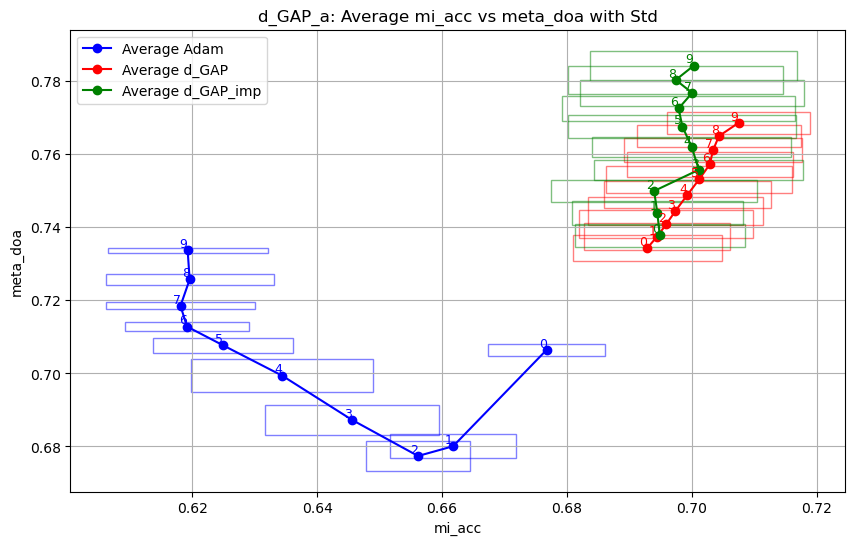

In [13]:
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Ellipse
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle

d_GAP_a = [({0: {'mi_acc': 0.685695230960846}, 1: {'mi_acc': 0.7016633152961731}, 2: {'mi_acc': 0.6994011998176575}, 3: {'mi_acc': 0.7025948166847229}, 4: {'mi_acc': 0.704457700252533}, 5: {'mi_acc': 0.7021955847740173}, 6: {'mi_acc': 0.7036593556404114}, 7: {'mi_acc': 0.7023286819458008}, 8: {'mi_acc': 0.7072521448135376}, 9: {'mi_acc': 0.7031270861625671}}, {0: {'meta_doa': 0.7425898990548128}, 1: {'meta_doa': 0.749311884665743}, 2: {'meta_doa': 0.7553632393188774}, 3: {'meta_doa': 0.7610620790878874}, 4: {'meta_doa': 0.7676201808622714}, 5: {'meta_doa': 0.7732922975842338}, 6: {'meta_doa': 0.7778605529395959}, 7: {'meta_doa': 0.7814299670893767}, 8: {'meta_doa': 0.783476366305087}, 9: {'meta_doa': 0.7861964471779208}}),
            ({0: {'mi_acc': 0.6924816966056824}, 1: {'mi_acc': 0.688090443611145}, 2: {'mi_acc': 0.6890219449996948}, 3: {'mi_acc': 0.6924816966056824}, 4: {'mi_acc': 0.6988689303398132}, 5: {'mi_acc': 0.699268102645874}, 6: {'mi_acc': 0.7045907974243164}, 7: {'mi_acc': 0.7085828185081482}, 8: {'mi_acc': 0.7137724161148071}, 9: {'mi_acc': 0.7129740118980408}}, {0: {'meta_doa': 0.7375820395563277}, 1: {'meta_doa': 0.743702927822403}, 2: {'meta_doa': 0.7496316102820149}, 3: {'meta_doa': 0.7556105729304318}, 4: {'meta_doa': 0.7622220184721762}, 5: {'meta_doa': 0.7680864617307456}, 6: {'meta_doa': 0.7732972247203452}, 7: {'meta_doa': 0.7775575861063695}, 8: {'meta_doa': 0.7806692145019951}, 9: {'meta_doa': 0.7845093807608309}}),
            ({0: {'mi_acc': 0.6778442859649658}, 1: {'mi_acc': 0.6746506690979004}, 2: {'mi_acc': 0.6694610714912415}, 3: {'mi_acc': 0.6783765554428101}, 4: {'mi_acc': 0.6773120164871216}, 5: {'mi_acc': 0.6710578799247742}, 6: {'mi_acc': 0.6709247827529907}, 7: {'mi_acc': 0.672920823097229}, 8: {'mi_acc': 0.6761144399642944}, 9: {'mi_acc': 0.6803725957870483}}, {0: {'meta_doa': 0.734784130278634}, 1: {'meta_doa': 0.7414256217018026}, 2: {'meta_doa': 0.7484298542067631}, 3: {'meta_doa': 0.7549252857544732}, 4: {'meta_doa': 0.7617443577838665}, 5: {'meta_doa': 0.76795092250738}, 6: {'meta_doa': 0.773430443606006}, 7: {'meta_doa': 0.7784805595182239}, 8: {'meta_doa': 0.7834176500788027}, 9: {'meta_doa': 0.7885397658166611}}),
            ({0: {'mi_acc': 0.6975382566452026}, 1: {'mi_acc': 0.6994011998176575}, 2: {'mi_acc': 0.693812370300293}, 3: {'mi_acc': 0.6986027956008911}, 4: {'mi_acc': 0.696207582950592}, 5: {'mi_acc': 0.6903526186943054}, 6: {'mi_acc': 0.6830338835716248}, 7: {'mi_acc': 0.6811710000038147}, 8: {'mi_acc': 0.6751829385757446}, 9: {'mi_acc': 0.6757152080535889}}, {0: {'meta_doa': 0.7351373608841452}, 1: {'meta_doa': 0.7414663209396681}, 2: {'meta_doa': 0.7477462158690142}, 3: {'meta_doa': 0.7543154742438181}, 4: {'meta_doa': 0.7606192501042921}, 5: {'meta_doa': 0.7663572060941142}, 6: {'meta_doa': 0.772058872833216}, 7: {'meta_doa': 0.7775053494436348}, 8: {'meta_doa': 0.7829197281055174}, 9: {'meta_doa': 0.7882289762326431}}),
            ({0: {'mi_acc': 0.7145708203315735}, 1: {'mi_acc': 0.7109780311584473}, 2: {'mi_acc': 0.7152361869812012}, 3: {'mi_acc': 0.7186959385871887}, 4: {'mi_acc': 0.7131071090698242}, 5: {'mi_acc': 0.7067198753356934}, 6: {'mi_acc': 0.7095142602920532}, 7: {'mi_acc': 0.7168329954147339}, 8: {'mi_acc': 0.7071190476417542}, 9: {'mi_acc': 0.7040585279464722}}, {0: {'meta_doa': 0.7398969855524276}, 1: {'meta_doa': 0.7462963056171483}, 2: {'meta_doa': 0.7521570500168024}, 3: {'meta_doa': 0.7580234798106895}, 4: {'meta_doa': 0.7642125091861154}, 5: {'meta_doa': 0.7700751496641978}, 6: {'meta_doa': 0.7758483714647566}, 7: {'meta_doa': 0.7813191969410814}, 8: {'meta_doa': 0.7863799072203295}, 9: {'meta_doa': 0.7920269574924161}})
            ]

d_Adam = [({0: {'mi_acc': 0.6924816966056824}, 1: {'mi_acc': 0.6771789789199829}, 2: {'mi_acc': 0.670791745185852}, 3: {'mi_acc': 0.6691949367523193}, 4: {'mi_acc': 0.6582834124565125}, 5: {'mi_acc': 0.642980694770813}, 6: {'mi_acc': 0.6351297497749329}, 7: {'mi_acc': 0.6303393244743347}, 8: {'mi_acc': 0.6345974802970886}, 9: {'mi_acc': 0.6364603638648987}}, {0: {'meta_doa': 0.7084562737120852}, 1: {'meta_doa': 0.6850781554614311}, 2: {'meta_doa': 0.682928486959986}, 3: {'meta_doa': 0.693269915487039}, 4: {'meta_doa': 0.7054253448774888}, 5: {'meta_doa': 0.7099752393738058}, 6: {'meta_doa': 0.714113389000296}, 7: {'meta_doa': 0.7173318827510364}, 8: {'meta_doa': 0.7235426267672171}, 9: {'meta_doa': 0.7325243926819851}}),
          ({0: {'mi_acc': 0.6754490733146667}, 1: {'mi_acc': 0.6600132584571838}, 2: {'mi_acc': 0.6540252566337585}, 3: {'mi_acc': 0.6419161558151245}, 4: {'mi_acc': 0.6347305178642273}, 5: {'mi_acc': 0.6254158020019531}, 6: {'mi_acc': 0.6157019138336182}, 7: {'mi_acc': 0.6106453537940979}, 8: {'mi_acc': 0.6081171035766602}, 9: {'mi_acc': 0.6082501411437988}}, {0: {'meta_doa': 0.7039300763107585}, 1: {'meta_doa': 0.6772116043240841}, 2: {'meta_doa': 0.6724957867685301}, 3: {'meta_doa': 0.68258010098621}, 4: {'meta_doa': 0.6958730404034936}, 5: {'meta_doa': 0.7058072795509229}, 6: {'meta_doa': 0.712499647195145}, 7: {'meta_doa': 0.7176315541533602}, 8: {'meta_doa': 0.7267020862522149}, 9: {'meta_doa': 0.7340983508301016}}),
          ({0: {'mi_acc': 0.6751829385757446}, 1: {'mi_acc': 0.6633399724960327}, 2: {'mi_acc': 0.6504324674606323}, 3: {'mi_acc': 0.6320691704750061}, 4: {'mi_acc': 0.6210246086120605}, 5: {'mi_acc': 0.6214237809181213}, 6: {'mi_acc': 0.6198269724845886}, 7: {'mi_acc': 0.6303393244743347}, 8: {'mi_acc': 0.6302062273025513}, 9: {'mi_acc': 0.6274118423461914}}, {0: {'meta_doa': 0.7070339033903139}, 1: {'meta_doa': 0.6798287946090771}, 2: {'meta_doa': 0.6785959878608936}, 3: {'meta_doa': 0.6895077653169002}, 4: {'meta_doa': 0.7030863960827985}, 5: {'meta_doa': 0.7098424786561868}, 6: {'meta_doa': 0.7142438645192785}, 7: {'meta_doa': 0.7194876444982768}, 8: {'meta_doa': 0.7265793916191463}, 9: {'meta_doa': 0.7333845381735589}}),
          ({0: {'mi_acc': 0.6734530925750732}, 1: {'mi_acc': 0.6592148542404175}, 2: {'mi_acc': 0.6530938148498535}, 3: {'mi_acc': 0.6440452337265015}, 4: {'mi_acc': 0.6333998441696167}, 5: {'mi_acc': 0.6226214170455933}, 6: {'mi_acc': 0.6170325875282288}, 7: {'mi_acc': 0.6157019138336182}, 8: {'mi_acc': 0.6211576461791992}, 9: {'mi_acc': 0.6178309917449951}}, {0: {'meta_doa': 0.7061865035105463}, 1: {'meta_doa': 0.6773145555926567}, 2: {'meta_doa': 0.6746968769817094}, 3: {'meta_doa': 0.6848663876447532}, 4: {'meta_doa': 0.69641817450702}, 5: {'meta_doa': 0.7054941199124167}, 6: {'meta_doa': 0.7114060365727629}, 7: {'meta_doa': 0.7187693101650978}, 8: {'meta_doa': 0.7269312246838588}, 9: {'meta_doa': 0.7344987323374761}}),
          ({0: {'mi_acc': 0.667198896408081}, 1: {'mi_acc': 0.6491017937660217}, 2: {'mi_acc': 0.6524284482002258}, 3: {'mi_acc': 0.6405854821205139}, 4: {'mi_acc': 0.6243512630462646}, 5: {'mi_acc': 0.6122421622276306}, 6: {'mi_acc': 0.6079840064048767}, 7: {'mi_acc': 0.6034597158432007}, 8: {'mi_acc': 0.6037258505821228}, 9: {'mi_acc': 0.6062541604042053}}, {0: {'meta_doa': 0.706544584203283}, 1: {'meta_doa': 0.6807789377223952}, 2: {'meta_doa': 0.6781352255768651}, 3: {'meta_doa': 0.6860748886578804}, 4: {'meta_doa': 0.6961086188094784}, 5: {'meta_doa': 0.7070815545241518}, 6: {'meta_doa': 0.7116876628710169}, 7: {'meta_doa': 0.7190714002027461}, 8: {'meta_doa': 0.7246432490552572}, 9: {'meta_doa': 0.7336166892756256}})]

d_GAP = [({0: {'mi_acc': 0.7107118964195251}, 1: {'mi_acc': 0.7121756076812744}, 2: {'mi_acc': 0.7178975343704224}, 3: {'mi_acc': 0.7198935151100159}, 4: {'mi_acc': 0.7209580540657043}, 5: {'mi_acc': 0.721623420715332}, 6: {'mi_acc': 0.7204257845878601}, 7: {'mi_acc': 0.7220225930213928}, 8: {'mi_acc': 0.7226879596710205}, 9: {'mi_acc': 0.7245509028434753}}, {0: {'meta_doa': 0.7369116313994888}, 1: {'meta_doa': 0.7401776139501453}, 2: {'meta_doa': 0.7435959447412918}, 3: {'meta_doa': 0.7471816729632257}, 4: {'meta_doa': 0.7515102817188273}, 5: {'meta_doa': 0.7555688320721008}, 6: {'meta_doa': 0.7594621140320155}, 7: {'meta_doa': 0.7629448505501149}, 8: {'meta_doa': 0.7665633910411122}, 9: {'meta_doa': 0.7698878509688218}})
,({0: {'mi_acc': 0.6952760815620422}, 1: {'mi_acc': 0.6956753134727478}, 2: {'mi_acc': 0.6971390247344971}, 3: {'mi_acc': 0.6986027956008911}, 4: {'mi_acc': 0.6971390247344971}, 5: {'mi_acc': 0.7048569321632385}, 6: {'mi_acc': 0.7079174518585205}, 7: {'mi_acc': 0.7081835865974426}, 8: {'mi_acc': 0.7064537405967712}, 9: {'mi_acc': 0.7065867781639099}}, {0: {'meta_doa': 0.7313380403345429}, 1: {'meta_doa': 0.7343466544283327}, 2: {'meta_doa': 0.7376895358431659}, 3: {'meta_doa': 0.7414367255407358}, 4: {'meta_doa': 0.74594787427979}, 5: {'meta_doa': 0.7501882120145547}, 6: {'meta_doa': 0.7544839076468445}, 7: {'meta_doa': 0.7586661725182249}, 8: {'meta_doa': 0.7631511144921646}, 9: {'meta_doa': 0.7672700025175572}})
,({0: {'mi_acc': 0.6863605976104736}, 1: {'mi_acc': 0.6879574060440063}, 2: {'mi_acc': 0.6911510229110718}, 3: {'mi_acc': 0.6930139660835266}, 4: {'mi_acc': 0.6978043913841248}, 5: {'mi_acc': 0.7011310458183289}, 6: {'mi_acc': 0.7003326416015625}, 7: {'mi_acc': 0.7007318735122681}, 8: {'mi_acc': 0.7011310458183289}, 9: {'mi_acc': 0.7045907974243164}}, {0: {'meta_doa': 0.7387093409723344}, 1: {'meta_doa': 0.7420726452004549}, 2: {'meta_doa': 0.7456232275642273}, 3: {'meta_doa': 0.7492461085971049}, 4: {'meta_doa': 0.7537760084644033}, 5: {'meta_doa': 0.7581066203152549}, 6: {'meta_doa': 0.7621718509197886}, 7: {'meta_doa': 0.7658752311884067}, 8: {'meta_doa': 0.7694580362905937}, 9: {'meta_doa': 0.7726850967029422}})
,({0: {'mi_acc': 0.6935462355613708}, 1: {'mi_acc': 0.6956753134727478}, 2: {'mi_acc': 0.6936792731285095}, 3: {'mi_acc': 0.6935462355613708}, 4: {'mi_acc': 0.6963406205177307}, 5: {'mi_acc': 0.698336660861969}, 6: {'mi_acc': 0.7019294500350952}, 7: {'mi_acc': 0.7036593556404114}, 8: {'mi_acc': 0.7055222392082214}, 9: {'mi_acc': 0.7092481255531311}}, {0: {'meta_doa': 0.734146425245785}, 1: {'meta_doa': 0.7370432311034407}, 2: {'meta_doa': 0.74019802539909}, 3: {'meta_doa': 0.7436612565858485}, 4: {'meta_doa': 0.7478979334993907}, 5: {'meta_doa': 0.7517718469050243}, 6: {'meta_doa': 0.755358966055041}, 7: {'meta_doa': 0.7585318981304909}, 8: {'meta_doa': 0.7616070045863621}, 9: {'meta_doa': 0.7645023820139965}})
,({0: {'mi_acc': 0.6785096526145935}, 1: {'mi_acc': 0.6806387305259705}, 2: {'mi_acc': 0.679574191570282}, 3: {'mi_acc': 0.6817032098770142}, 4: {'mi_acc': 0.6842315196990967}, 5: {'mi_acc': 0.6799733638763428}, 6: {'mi_acc': 0.6838322877883911}, 7: {'mi_acc': 0.6823685765266418}, 8: {'mi_acc': 0.6859613656997681}, 9: {'mi_acc': 0.692614734172821}}, {0: {'meta_doa': 0.7304106790249607}, 1: {'meta_doa': 0.7332284705808003}, 2: {'meta_doa': 0.7366063234902659}, 3: {'meta_doa': 0.7403180417740645}, 4: {'meta_doa': 0.7450376501605802}, 5: {'meta_doa': 0.7498141948627648}, 6: {'meta_doa': 0.7544579406393028}, 7: {'meta_doa': 0.7590424355716754}, 8: {'meta_doa': 0.7638866425116998}, 9: {'meta_doa': 0.76851892010849}})
]
d_GAP_imp = [({0: {'mi_acc': 0.7160345911979675}, 1: {'mi_acc': 0.7112441658973694}, 2: {'mi_acc': 0.7184298038482666}, 3: {'mi_acc': 0.7225548624992371}, 4: {'mi_acc': 0.7174983024597168}, 5: {'mi_acc': 0.717099130153656}, 6: {'mi_acc': 0.7184298038482666}, 7: {'mi_acc': 0.7213572859764099}, 8: {'mi_acc': 0.7140385508537292}, 9: {'mi_acc': 0.7186959385871887}}, {0: {'meta_doa': 0.7397406324951549}, 1: {'meta_doa': 0.74578505307349}, 2: {'meta_doa': 0.7512004352226899}, 3: {'meta_doa': 0.7566045637421255}, 4: {'meta_doa': 0.7624296709929537}, 5: {'meta_doa': 0.7677490248990957}, 6: {'meta_doa': 0.772579951471229}, 7: {'meta_doa': 0.7765247405674733}, 8: {'meta_doa': 0.7797132600945084}, 9: {'meta_doa': 0.7834471389932254}}),
             ({0: {'mi_acc': 0.6870259046554565}, 1: {'mi_acc': 0.6998003721237183}, 2: {'mi_acc': 0.6958083510398865}, 3: {'mi_acc': 0.7085828185081482}, 4: {'mi_acc': 0.7065867781639099}, 5: {'mi_acc': 0.7056553363800049}, 6: {'mi_acc': 0.7049899697303772}, 7: {'mi_acc': 0.706852912902832}, 8: {'mi_acc': 0.7115103006362915}, 9: {'mi_acc': 0.7087158560752869}}, {0: {'meta_doa': 0.7420978925898805}, 1: {'meta_doa': 0.7485025240765185}, 2: {'meta_doa': 0.7542877433578068}, 3: {'meta_doa': 0.7597665460652698}, 4: {'meta_doa': 0.7663837224770829}, 5: {'meta_doa': 0.7723938907610646}, 6: {'meta_doa': 0.7775750418683307}, 7: {'meta_doa': 0.7820883904120808}, 8: {'meta_doa': 0.7851130477593007}, 9: {'meta_doa': 0.7887356847974121}}),
({0: {'mi_acc': 0.6923485994338989}, 1: {'mi_acc': 0.6883565783500671}, 2: {'mi_acc': 0.6892880797386169}, 3: {'mi_acc': 0.694743812084198}, 4: {'mi_acc': 0.6996673345565796}, 5: {'mi_acc': 0.6999334692955017}, 6: {'mi_acc': 0.6990019679069519}, 7: {'mi_acc': 0.6971390247344971}, 8: {'mi_acc': 0.6911510229110718}, 9: {'mi_acc': 0.6935462355613708}}, {0: {'meta_doa': 0.7375713501602505}, 1: {'meta_doa': 0.7436957012457759}, 2: {'meta_doa': 0.7495316847824807}, 3: {'meta_doa': 0.7552203896727276}, 4: {'meta_doa': 0.7611949566450502}, 5: {'meta_doa': 0.7663649189251024}, 6: {'meta_doa': 0.7708974202170193}, 7: {'meta_doa': 0.7748446846115284}, 8: {'meta_doa': 0.7782005132870223}, 9: {'meta_doa': 0.7818644568450299}}),
({0: {'mi_acc': 0.6802394986152649}, 1: {'mi_acc': 0.6746506690979004}, 2: {'mi_acc': 0.6722554564476013}, 3: {'mi_acc': 0.677445113658905}, 4: {'mi_acc': 0.6742514967918396}, 5: {'mi_acc': 0.6681303977966309}, 6: {'mi_acc': 0.6677311658859253}, 7: {'mi_acc': 0.6722554564476013}, 8: {'mi_acc': 0.671457052230835}, 9: {'mi_acc': 0.6753160357475281}}, {0: {'meta_doa': 0.7345687263618308}, 1: {'meta_doa': 0.7410178900203185}, 2: {'meta_doa': 0.7478989087815044}, 3: {'meta_doa': 0.7542544640477005}, 4: {'meta_doa': 0.7610556793002021}, 5: {'meta_doa': 0.7673503490336786}, 6: {'meta_doa': 0.7728332351219653}, 7: {'meta_doa': 0.777883715265199}, 8: {'meta_doa': 0.7828379176048054}, 9: {'meta_doa': 0.7879944608541867}}),
({0: {'mi_acc': 0.6987358331680298}, 1: {'mi_acc': 0.698336660861969}, 2: {'mi_acc': 0.6940785050392151}, 3: {'mi_acc': 0.7023286819458008}, 4: {'mi_acc': 0.7019294500350952}, 5: {'mi_acc': 0.7016633152961731}, 6: {'mi_acc': 0.699268102645874}, 7: {'mi_acc': 0.7027278542518616}, 8: {'mi_acc': 0.6990019679069519}, 9: {'mi_acc': 0.7052561044692993}}, {0: {'meta_doa': 0.7348493590700207}, 1: {'meta_doa': 0.7407728337498414}, 2: {'meta_doa': 0.7466102875744813}, 3: {'meta_doa': 0.7527167335384894}, 4: {'meta_doa': 0.7587013572041754}, 5: {'meta_doa': 0.7638678859713598}, 6: {'meta_doa': 0.7685892569013142}, 7: {'meta_doa': 0.7723946701094785}, 8: {'meta_doa': 0.7756456020341892}, 9: {'meta_doa': 0.7789824673478142}})

]

    # Plot average curve with uncertainty bands
plt.figure(figsize=(10, 6))


colors = ['blue', 'red', 'green', 'orange']
labels = ['Adam', 'd_GAP','d_GAP_imp']

for xp, color, label in zip([d_Adam, d_GAP,d_GAP_imp], colors, labels):
    mi_acc_array = []
    meta_doa_array = []

    for d in xp:
        mi_acc = [d[0][i]['mi_acc'] for i in range(len(d[0]))]
        meta_doa = [d[1][i]['meta_doa'] for i in range(len(d[1]))]
        mi_acc_array.append(mi_acc)
        meta_doa_array.append(meta_doa)

    mi_acc_array = torch.tensor(mi_acc_array)
    meta_doa_array = torch.tensor(meta_doa_array)

    # Compute mean and std across curves for each step
    mean_mi   = mi_acc_array.mean(dim=0)
    std_mi    = mi_acc_array.std(dim=0)
    mean_meta = meta_doa_array.mean(dim=0)
    std_meta  = meta_doa_array.std(dim=0)

    # Plot average curve
    plt.plot(mean_mi, mean_meta, marker='o', color=color, label=f'Average {label}')
    ax = plt.gca()

    # Add uncertainty boxes
    mean_mi_np   = mean_mi.cpu().numpy()
    std_mi_np    = std_mi.cpu().numpy()
    mean_meta_np = mean_meta.cpu().numpy()
    std_meta_np  = std_meta.cpu().numpy()

    for x0, y0, dx, dy in zip(mean_mi_np, mean_meta_np, std_mi_np, std_meta_np):
        rect = Rectangle((x0-dx, y0-dy), 2*dx, 2*dy,
                         edgecolor=color, facecolor='none', alpha=0.5)
        ax.add_patch(rect)

    # Annotate each point
    for idx, (x, y) in enumerate(zip(mean_mi, mean_meta)):
        plt.text(x, y, str(idx), fontsize=9, ha='right', va='bottom', color=color)

plt.xlabel('mi_acc')
plt.ylabel('meta_doa')
plt.title('d_GAP_a: Average mi_acc vs meta_doa with Std')
plt.grid(True)
plt.legend()
plt.show()



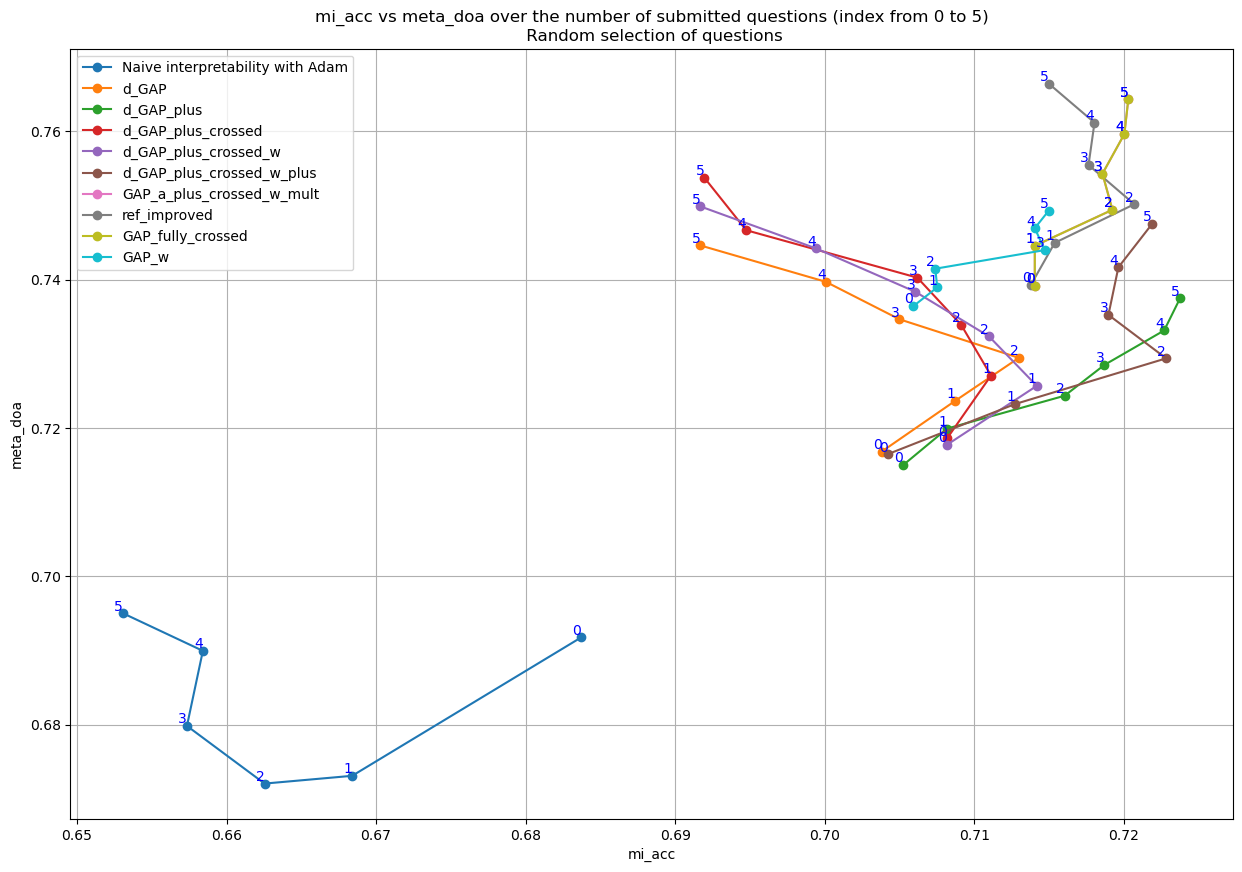

In [8]:
d_GAP_plus =  ({0: {'mi_acc': 0.7052561044692993},
  1: {'mi_acc': 0.7081835865974426},
  2: {'mi_acc': 0.7160345911979675},
  3: {'mi_acc': 0.7186959385871887},
  4: {'mi_acc': 0.7226879596710205},
  5: {'mi_acc': 0.723752498626709}},
 {0: {'meta_doa': 0.7150174768490059},
  1: {'meta_doa': 0.7199160051676918},
  2: {'meta_doa': 0.7243391187001821},
  3: {'meta_doa': 0.7284976827174179},
  4: {'meta_doa': 0.7331423505222098},
  5: {'meta_doa': 0.7374840547174377}})
d_GAP_plus_crossed = ({0: {'mi_acc': 0.7081835865974426},
  1: {'mi_acc': 0.7111110687255859},
  2: {'mi_acc': 0.7091150879859924},
  3: {'mi_acc': 0.7061876058578491},
  4: {'mi_acc': 0.694743812084198},
  5: {'mi_acc': 0.6919494271278381}},
 {0: {'meta_doa': 0.7186161437407594},
  1: {'meta_doa': 0.7270571981473226},
  2: {'meta_doa': 0.7339044867773703},
  3: {'meta_doa': 0.7402605652480061},
  4: {'meta_doa': 0.7466617516897138},
  5: {'meta_doa': 0.7537287823271313}})
d_GAP_plus_crossed_w = ({0: {'mi_acc': 0.7081835865974426},
  1: {'mi_acc': 0.7141716480255127},
  2: {'mi_acc': 0.7109780311584473},
  3: {'mi_acc': 0.7060545086860657},
  4: {'mi_acc': 0.6994011998176575},
  5: {'mi_acc': 0.691683292388916}},
 {0: {'meta_doa': 0.7177438982952528},
  1: {'meta_doa': 0.7256711904579174},
  2: {'meta_doa': 0.7323409393801739},
  3: {'meta_doa':0.738355797789396},
  4: {'meta_doa': 0.7442126141891328},
  5: {'meta_doa': 0.7498648304543734}})

d_GAP_plus_crossed_w_plus = ({0: {'mi_acc': 0.7041915655136108},
  1: {'mi_acc': 0.7127078771591187},
  2: {'mi_acc': 0.7228209972381592},
  3: {'mi_acc': 0.7189620733261108},
  4: {'mi_acc': 0.7196273803710938},
  5: {'mi_acc': 0.7218895554542542}},
 {0: {'meta_doa': 0.7164438432911314},
  1: {'meta_doa': 0.7232090701737655},
  2: {'meta_doa': 0.7293787143615836},
  3: {'meta_doa': 0.7352419637018153},
  4: {'meta_doa': 0.7416571507322121},
  5: {'meta_doa': 0.7475306731914435}})
d_GAP_ss_L3 = ({0: {'mi_acc': 0.6955422163009644},
  1: {'mi_acc': 0.6971390247344971},
  2: {'mi_acc': 0.7035262584686279},
  3: {'mi_acc': 0.7045907974243164},
  4: {'mi_acc': 0.7144377827644348},
  5: {'mi_acc': 0.7136393785476685}},
 {0: {'meta_doa': 0.7150062438148472},
  1: {'meta_doa': 0.7199137494916276},
  2: {'meta_doa': 0.7243672262171958},
  3: {'meta_doa': 0.7285311723080934},
  4: {'meta_doa': 0.7332193919645746},
  5: {'meta_doa': 0.7374240924596362}})
d_GAP = ({0: {'mi_acc': 0.70379239320755},
  1: {'mi_acc': 0.7087158560752869},
  2: {'mi_acc': 0.7129740118980408},
  3: {'mi_acc': 0.7049899697303772},
  4: {'mi_acc': 0.7000665068626404},
  5: {'mi_acc': 0.691683292388916}},
 {0: {'meta_doa': 0.7167901163742122},
  1: {'meta_doa': 0.7236510904578816},
  2: {'meta_doa': 0.7294495545873044},
  3: {'meta_doa': 0.7346486942411117},
  4: {'meta_doa': 0.7397027233748683},
  5: {'meta_doa': 0.7446037651747923}})
Adam_interp = ({0: {'mi_acc': 0.6836992502212524},
  1: {'mi_acc': 0.668396532535553},
  2: {'mi_acc': 0.6625415682792664},
  3: {'mi_acc': 0.6573519706726074},
  4: {'mi_acc': 0.6584165096282959},
  5: {'mi_acc': 0.6530938148498535}},
 {0: {'meta_doa': 0.6917362627145501},
  1: {'meta_doa': 0.6730835889790893},
  2: {'meta_doa': 0.6720365839984437},
  3: {'meta_doa': 0.679813780250938},
  4: {'meta_doa': 0.689935901967663},
  5: {'meta_doa': 0.6949845143894253}})

GAP_a_plus_crossed_w_mult = ({0: {'mi_acc': 0.7140385508537292},
  1: {'mi_acc': 0.7140385508537292},
  2: {'mi_acc': 0.719228208065033},
  3: {'mi_acc': 0.7185628414154053},
  4: {'mi_acc': 0.7200266122817993},
  5: {'mi_acc': 0.7202927470207214}},
 {0: {'meta_doa': 0.739173959179289},
  1: {'meta_doa': 0.7445562245864692},
  2: {'meta_doa': 0.7494151805130439},
  3: {'meta_doa': 0.7542770391551334},
  4: {'meta_doa': 0.7596265232514319},
  5: {'meta_doa': 0.7643214159062643}})

ref_improved = ({0: {'mi_acc': 0.7137724161148071},
  1: {'mi_acc': 0.7153692245483398},
  2: {'mi_acc': 0.7206919193267822},
  3: {'mi_acc': 0.7176313996315002},
  4: {'mi_acc': 0.718030571937561},
  5: {'mi_acc': 0.714970052242279}},
 {0: {'meta_doa': 0.739269749591168},
  1: {'meta_doa': 0.7449549413576932},
  2: {'meta_doa': 0.7501654679728524},
  3: {'meta_doa': 0.7554555920596726},
  4: {'meta_doa': 0.7611656706047445},
  5: {'meta_doa': 0.7664340197883313}})
GAP_fully_crossed = ({0: {'mi_acc': 0.7140385508537292}, 1: {'mi_acc': 0.7140385508537292}, 2: {'mi_acc': 0.719228208065033}, 3: {'mi_acc': 0.7185628414154053}, 4: {'mi_acc': 0.7200266122817993}, 5: {'mi_acc': 0.7202927470207214}}, {0: {'meta_doa': 0.739173959179289}, 1: {'meta_doa': 0.7445562245864692}, 2: {'meta_doa': 0.7494151805130439}, 3: {'meta_doa': 0.7542770391551334}, 4: {'meta_doa': 0.7596265232514319}, 5: {'meta_doa': 0.7643214159062643}})
GAP_w = ({0: {'mi_acc': 0.705921471118927}, 1: {'mi_acc': 0.7075182795524597}, 2: {'mi_acc': 0.7073851823806763}, 3: {'mi_acc': 0.7147039175033569}, 4: {'mi_acc': 0.7140385508537292}, 5: {'mi_acc': 0.714970052242279}}, {0: {'meta_doa': 0.7364233481916107}, 1: {'meta_doa': 0.7389597822836985}, 2: {'meta_doa': 0.7414671930984285}, 3: {'meta_doa': 0.7439796457015344}, 4: {'meta_doa': 0.7469339349484027}, 5: {'meta_doa': 0.7492947477607088}})



import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
for d,n in zip([Adam_interp,d_GAP,d_GAP_plus,d_GAP_plus_crossed,d_GAP_plus_crossed_w,d_GAP_plus_crossed_w_plus,GAP_a_plus_crossed_w_mult,ref_improved,GAP_fully_crossed,GAP_w],["Naive interpretability with Adam", "d_GAP","d_GAP_plus","d_GAP_plus_crossed","d_GAP_plus_crossed_w","d_GAP_plus_crossed_w_plus","GAP_a_plus_crossed_w_mult","ref_improved","GAP_fully_crossed","GAP_w"]):
    # Extract values from the dictionaries
    mi_acc_values = [d[0][i]['mi_acc'] for i in d[0]]
    meta_doa_values = [d[1][i]['meta_doa'] for i in d[1]]

    
    plt.plot(mi_acc_values, meta_doa_values, marker='o', label=n)

    # Add index labels to each point
    for idx, (xi, yi) in enumerate(zip(mi_acc_values, meta_doa_values)):
        plt.text(xi, yi, str(idx), fontsize=10, ha='right', va='bottom', color='blue')


plt.xlabel('mi_acc')
plt.ylabel('meta_doa')
plt.title('mi_acc vs meta_doa over the number of submitted questions (index from 0 to 5)\n Random selection of questions')
plt.grid(True)
plt.legend()
plt.show()

